https://www.youtube.com/watch?v=Wqmtf9SA_kk

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [230]:
data = pd.read_csv("nybolig_data.csv")

In [231]:
data

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_renovated,energy_label
0,https://www.nybolig.dk/villa/3100/arfriisvej/2...,A R Friis Vej 9 3100 Hornbæk,3100,villa,9975000,269,12.0,9,1895,1999.0,D
1,https://www.nybolig.dk/fritidshus/7990/akoldin...,A. Koldings Vej 8 Sillerslev 7990 Øster Assels,7990,fritidsbolig,1495000,96,0.0,4,2008,NaN,NaN
2,https://www.nybolig.dk/villa/6400/aabenraavej/...,Aabenraavej 103 Ragebøl 6400 Sønderborg,6400,villa,1295000,219,0.0,7,1924,NaN,E
3,https://www.nybolig.dk/villa/6100/aabenraavej/...,Aabenraavej 59 6100 Haderslev,6100,villa,2495000,226,35.0,6,1947,2010.0,C
4,https://www.nybolig.dk/villa/9240/aagade/27020...,Aagade 4 Vegger 9240 Nibe,9240,villa,495000,159,59.0,4,1958,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...
5420,https://www.nybolig.dk/villa/8210/oestrevej/25...,Østrevej 5 Hasle 8210 Aarhus V,8210,villa,5248000,111,90.0,6,1928,2012.0,C
5421,https://www.nybolig.dk/villa/8930/oestrupvej/2...,Østrupvej 11 Albæk 8930 Randers NØ,8930,villa,995000,231,0.0,6,1850,2006.0,E
5422,https://www.nybolig.dk/villa/7130/oestrupvej/2...,Østrupvej 26 Glud 7130 Juelsminde,7130,villa,895000,83,6.0,4,1952,NaN,D
5423,https://www.nybolig.dk/villa/7130/oestrupvej/2...,Østrupvej 49 Glud 7130 Juelsminde,7130,villa,3995000,241,0.0,7,1986,2008.0,A2010


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5425 entries, 0 to 5424
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             5425 non-null   object 
 1   address         5425 non-null   object 
 2   postal_code     5425 non-null   int64  
 3   type            5425 non-null   object 
 4   price           5425 non-null   int64  
 5   size            5425 non-null   int64  
 6   basement_size   4528 non-null   float64
 7   rooms           5425 non-null   int64  
 8   year_built      5425 non-null   int64  
 9   year_renovated  2049 non-null   float64
 10  energy_label    4789 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 466.3+ KB


In [233]:
from sklearn.model_selection import train_test_split

X = data.drop(['price'], axis = 1)
y = data['price']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [235]:
train_data = X_train.join(y_train)

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'size'}>,
        <Axes: title={'center': 'basement_size'}>],
       [<Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>,
        <Axes: title={'center': 'year_renovated'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >, <Axes: >]],
      dtype=object)

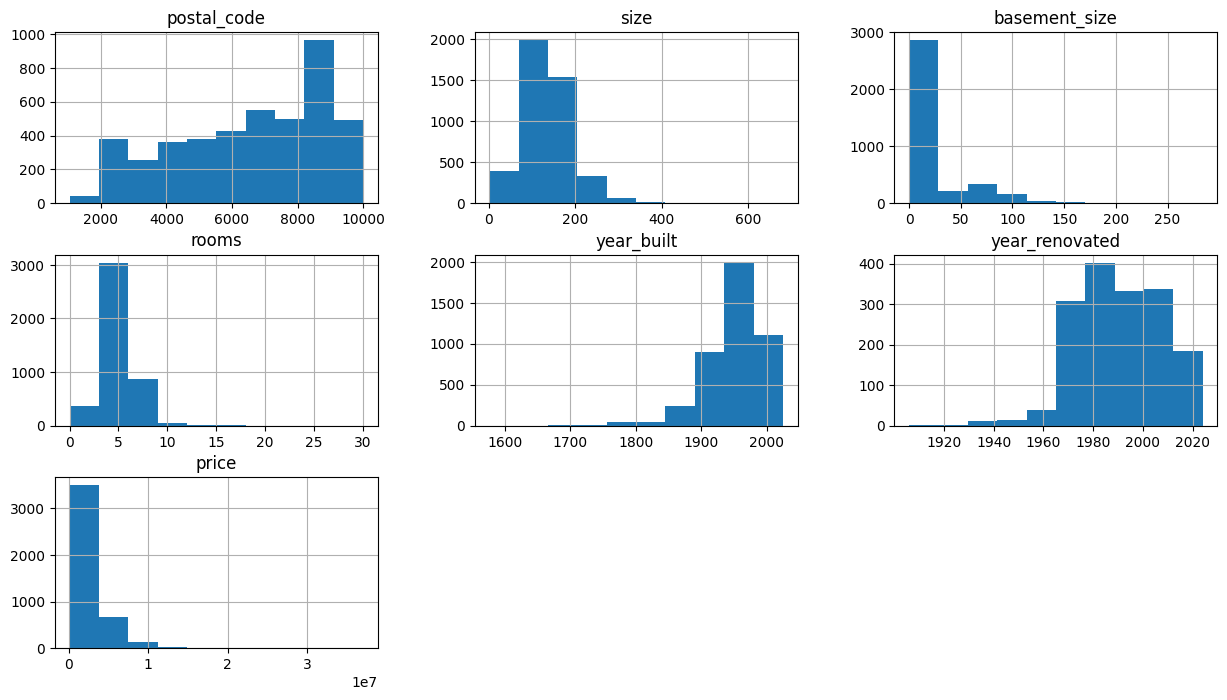

In [236]:
train_data.hist(figsize = (15, 8))

<Axes: >

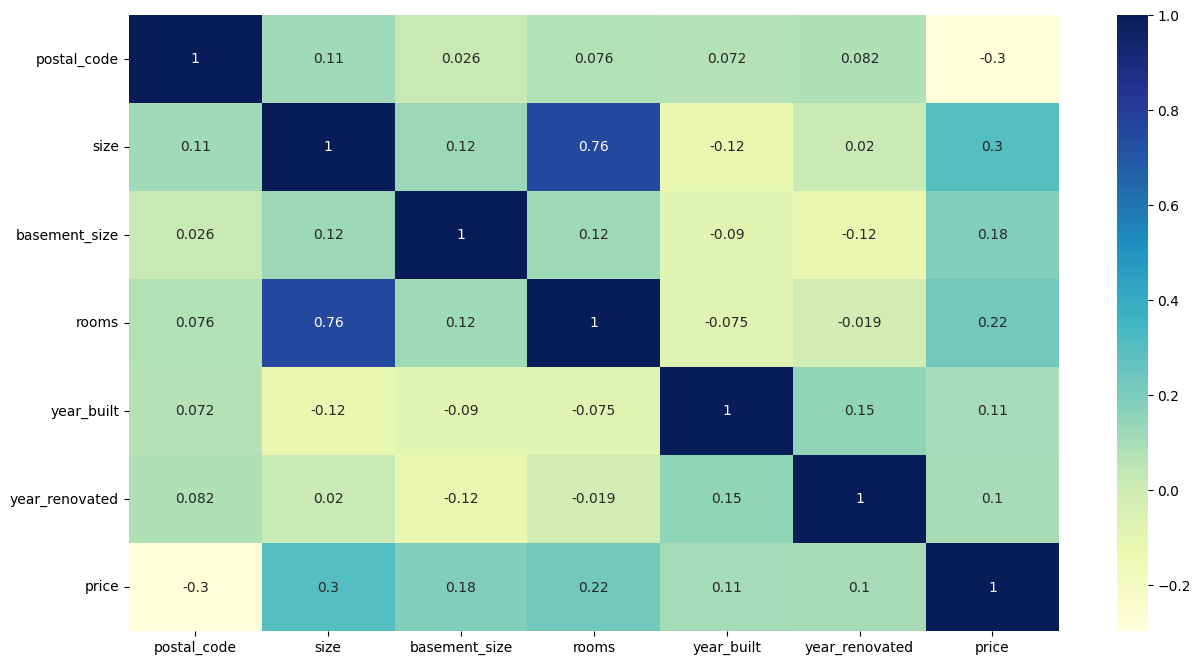

In [237]:
plt.figure(figsize = (15, 8))
# sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")
# Do heatmap of correlation only on the numerical data
sns.heatmap(train_data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

In [238]:
# Skew of the data
train_data.select_dtypes(include = np.number).skew()

postal_code      -0.426387
size              1.781795
basement_size     2.231004
rooms             1.904337
year_built       -1.478565
year_renovated   -0.282218
price             3.978125
dtype: float64

array([[<Axes: title={'center': 'original'}>,
        <Axes: title={'center': 'sqrt'}>,
        <Axes: title={'center': 'log'}>],
       [<Axes: title={'center': 'boxcox'}>,
        <Axes: title={'center': 'exp'}>,
        <Axes: title={'center': 'reciprocal'}>],
       [<Axes: title={'center': 'log_on_reciprocal'}>, <Axes: >,
        <Axes: >]], dtype=object)

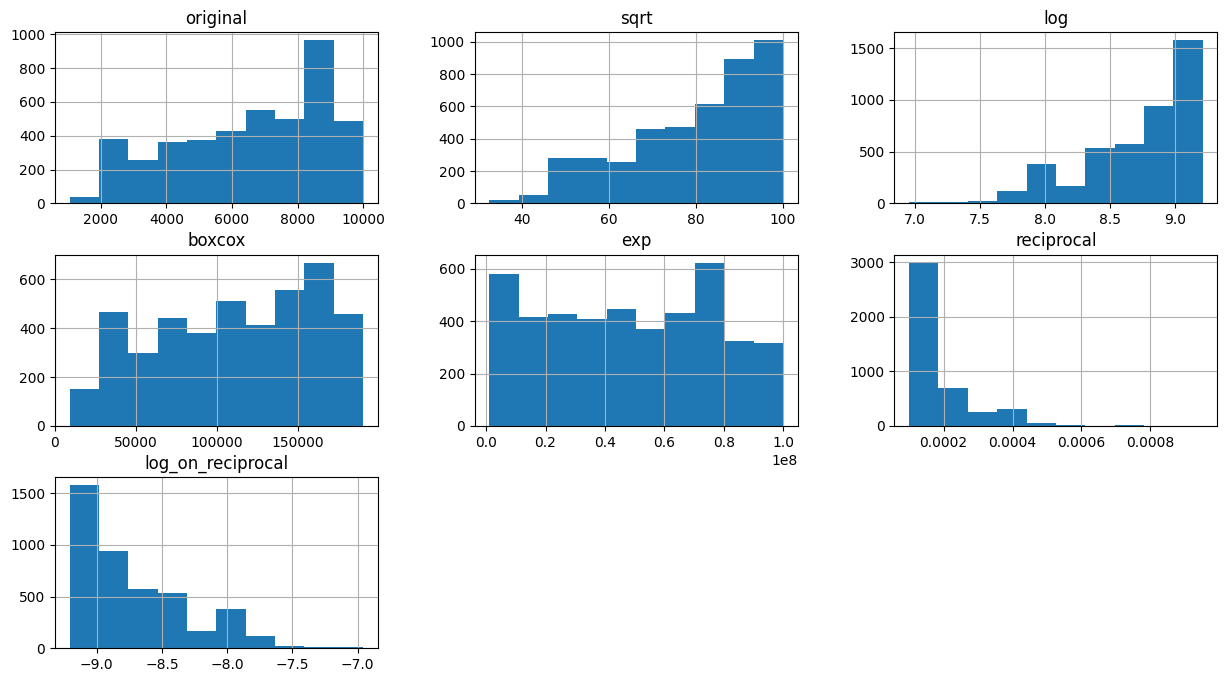

In [239]:
from scipy.stats import boxcox
# Testing different transformations of the postal_code
transformed_test = pd.DataFrame()
transformed_test['original'] = train_data['postal_code']
transformed_test['sqrt'] = np.sqrt(train_data['postal_code'])
transformed_test['log'] = np.log(train_data['postal_code'])
transformed_test['boxcox'], _ = boxcox(train_data['postal_code'])
transformed_test['exp'] = (train_data['postal_code']) ** 2
transformed_test['reciprocal'] = 1 / (train_data['postal_code'])
transformed_test['log_on_reciprocal'] = np.log(1 / (train_data['postal_code']))

transformed_test.hist(figsize = (15, 8))

In [240]:
# Skew of the different transformations
transformed_test.skew()

original            -0.426387
sqrt                -0.709540
log                 -1.064017
boxcox              -0.255399
exp                  0.013652
reciprocal           2.267909
log_on_reciprocal    1.064017
dtype: float64

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'size'}>,
        <Axes: title={'center': 'basement_size'}>],
       [<Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>,
        <Axes: title={'center': 'year_renovated'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >, <Axes: >]],
      dtype=object)

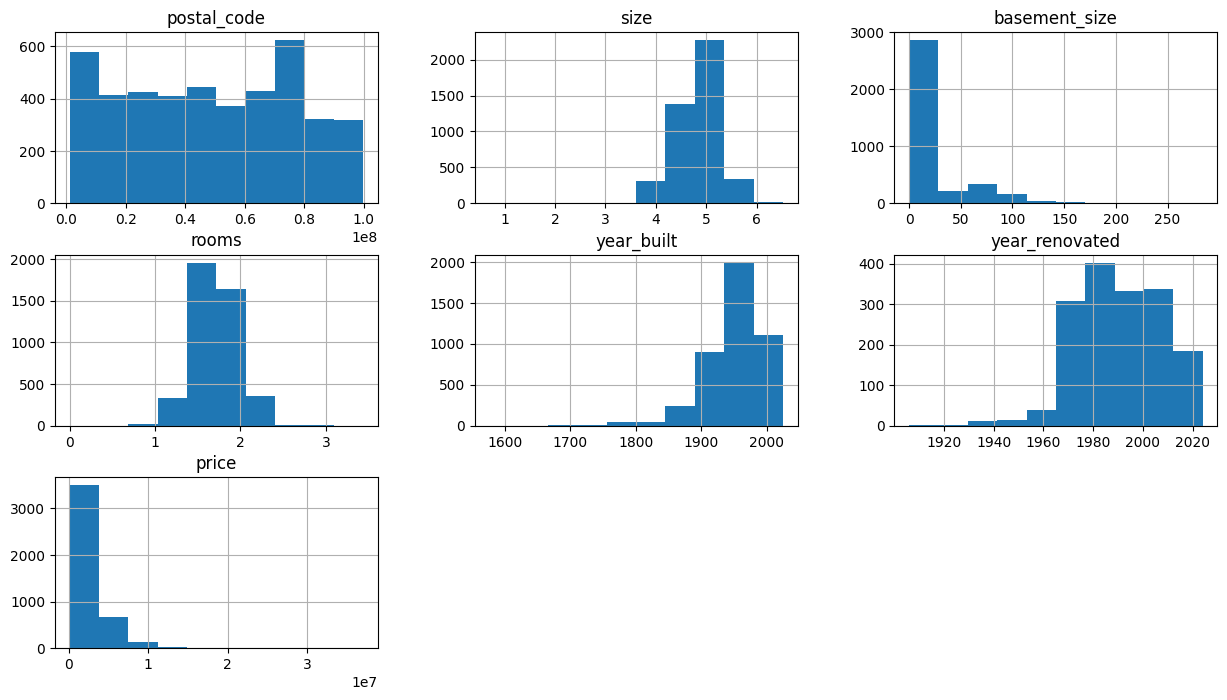

In [241]:
train_data['postal_code'] = (train_data['postal_code'] + 1) ** 2
train_data['rooms'] = np.log(train_data['rooms'] + 1)
train_data['size'] = np.log(train_data['size'] + 1)
train_data.hist(figsize = (15, 8))

In [242]:
train_data.type.value_counts()

type
villa             2838
ejerlejlighed      704
fritidsbolig       404
rækkehus           308
andelsbolig         71
villalejlighed      15
Name: count, dtype: int64